In [3]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import itertools
import argparse
import os

from line_profiler import LineProfiler
import pdb

In [11]:
pip install shapely==1.5.13

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
time=[35]
models = ["GAM"]
taxas=["Mammals"]
scenarios=["rcp26"]

In [12]:
#gfdl = xr.open_dataset("/storage/scratch/users/ch21o450/data/LandClim_Output//GAM/" + taxas[0] + "/GFDL-ESM2M/" + scenarios[0] + "/Circus_ranivorus_" +  str(time) +".nc" , decode_times=False)

    


IPSL =  xr.open_dataset("/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/" + taxas[0] +"/IPSL-CM5A-LR/" + scenarios[0] + "/Martes_melampus_" +  str(time) +".nc" , decode_times=False)

HadGEM2 =xr.open_dataset("/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/" + taxas[0]  +"/HadGEM2-ES/" + scenarios[0] + "/Martes_melampus_" +  str(time) +".nc" , decode_times=False)


KeyboardInterrupt: 

In [110]:
###tests#### 

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp60"]
    ssprcps_shorts = ["ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
#combinations = list(itertools.product(models, model_names))

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for i in range(len(GCMs)):  # Iterate over the range of GCMs length
            GCM = GCMs[i]
            bioscen_GCM = bioscen_GCMs[i]
            print("GCM", GCM)
            for scenario in scenarios:
                print ("Scneario", scenario)
                for l, ssprcp_short in enumerate(ssprcps_shorts):

                    convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                    dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                    dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                    available_file = os.listdir(dir_species)
                    available_names = [x.split(".csv")[0] for x in available_file]

                    formatted_names = []
                    
                    for species_name in available_names:
                        split_species_name = species_name.split("_")[:2]
                        formatted_species_name = " ".join(split_species_name)
                        formatted_names.append(formatted_species_name)

                    results = []
                    for i, species_name in enumerate(formatted_names[:1]):
                        formatted_species_name = species_name.replace(" ", "_")

                        for file_name in available_file:
                            if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                species_file = file_name
                                species_file2 = [x.split(".csv")[0] for x in species_file] 
                                break
                        else:
                            bioscen_species = None
                            continue
                            
                        bioscen_species = pd.read_csv(dir_species + file_name)

                        available_files_iucn = formatted_species_name + ".csv"
                        if available_files_iucn in os.listdir(dir_habclass):
                            IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                        else:
                            continue
                        
                        lon = bioscen_species["x"]
                        lat = bioscen_species["y"]
                        z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                        df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                        df = df.fillna(0)
                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')
                        
                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                            Habitats.drop('LUH', axis=1, inplace=True)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()
                        
                        LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                        #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                        ncfname = LandUseList
                        da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                        da_landuse = da_landuse.isel(time=time)

                        #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                        df_sdm =df

                        #build an empty np.array 
                        np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                        #isimip_lats = isimip['lat'].values
                        #isimip_lons = isimip['lon'].values

                        lats = da_landuse['lat'].values
                        lons = da_landuse['lon'].values

                        da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                        da_landclim = da_empty.assign_attrs(da_landuse)

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                        latitudes = df_sdm['lat'].unique()
                        longitudes = df_sdm['lon'].unique()

                        lats_sorted = np.sort(latitudes)
                        lons_sorted = np.sort(longitudes)

                       # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                        sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                        # Initialize the newvalue_array with NaNs instead of zeros
                        newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                        # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                        for i, lat in enumerate(lats_sorted):
                            for j, lon in enumerate(lons_sorted):
                                vals = sdm_dict.get((lat, lon), np.nan)
                                if not np.isnan(vals):
                                    newvalue_array[i, j] = vals


                        da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                        # Interpolate the values of newvalue to the dimensions of A
                        interpolated_values = da.interp(lat=lats, lon=lons)

                        # Add the interpolated values to the A DataArray
                        da_landuse['newvalue'] = interpolated_values
                        da_landuse['newvalue'] = interpolated_values.fillna(0)

                        #da_landuse['newvalue'] = da_landuse['newvalue'].where(~np.isnan(da_landuse['primf']))


                        keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                        keys = list(set(keys))
                        for variable in list(da_landuse.keys()):
                            if variable not in keys and variable != "newvalue":
                                del da_landuse[variable]
                                
                                

                        num_codes = 0
                        for code in keys: 
                            # Check if the code is "MARINE" and skip land-use filter if it is
                            if code == "MARINE":
                                pass
                            else:
                                num_codes += 1
                                # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                                da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]

                                da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                # Select the DataArrays ending in "_bin"
                                bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                # Multiply all the arrays together
                                sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)

                                # Assign the "product_bin" attribute to the da_landuse DataArray
                                da_landuse["sum_bin"] = sum_bin
                                da_landuse["sum_lu_binary"] = sum_lu_binary
                                #da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                #da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes
                                
                        
                        for variable in list(da_landuse.keys()):
                            if variable  in keys and variable != "newvalue":
                                del da_landuse[variable]
                                


                                print("Size of da_landuse in megabytes (MB): ", da_landuse.nbytes / (1024 * 1024))                                



GCM GFDL-ESM2M
Scneario rcp60
Size of da_landuse in megabytes (MB):  24.72748565673828
Size of da_landuse in megabytes (MB):  23.73871612548828
GCM IPSL-CM5A-LR
Scneario rcp60
Size of da_landuse in megabytes (MB):  24.72748565673828
Size of da_landuse in megabytes (MB):  23.73871612548828
GCM HadGEM2-ES
Scneario rcp60
Size of da_landuse in megabytes (MB):  24.72748565673828
Size of da_landuse in megabytes (MB):  23.73871612548828
GCM MIROC5
Scneario rcp60
Size of da_landuse in megabytes (MB):  24.72748565673828
Size of da_landuse in megabytes (MB):  23.73871612548828


In [34]:
scenarios=['rcp60']

In [65]:
 ssprcps_shorts[l]

'ssp460'

In [73]:
formatted_species_name

'Vulpes_vulpes'

In [109]:
rcp26 = da_landuse["sum_bin"]

In [111]:
rcp60 = da_landuse["sum_bin"]

In [77]:
diff =rcp26 -rcp60

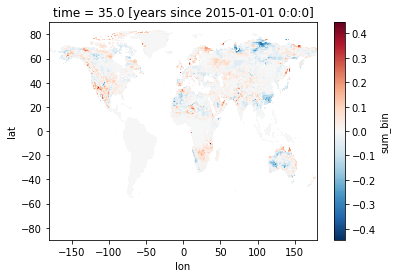

In [117]:
diff.plot()

In [82]:
scenario

'rcp60'

In [97]:
rcp26new = da_landuse["sum_bin"]

In [104]:
rcp60new = da_landuse["sum_bin"]

In [105]:
diff_new =rcp26new -rcp60new

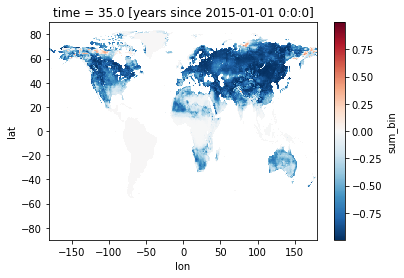

In [99]:
diff_new.plot()

In [100]:
diff26 = rcp26new - rcp26

In [112]:
diffdiff = rcp60new - rcp60

In [115]:
diffdiff.mean()

<xarray.DataArray 'sum_bin' ()>
array(0.)

In [103]:

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp60"]
    ssprcps_shorts = ["ssp460"]
elif time[0] == 85:
    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
combinations = list(itertools.product(models, model_names))
    # Load necessary data
convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:1]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                           # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                            sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                            # Initialize the newvalue_array with NaNs instead of zeros
                            newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                            # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    vals = sdm_dict.get((lat, lon), np.nan)
                                    if not np.isnan(vals):
                                        newvalue_array[i, j] = vals


                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            
                               
                            keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                            keys = list(set(keys))

                            num_codes = 0
                            for code in keys: 
                                # Check if the code is "MARINE" and skip land-use filter if it is
                                if code == "MARINE":
                                    pass
                                else:
                                    num_codes += 1
                                    # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                    np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                    da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]
                                    
                                    da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                    #da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]
                                    
                                    #da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                    #da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                    # Select the DataArrays ending in "_bin"
                                    bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                    #binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                    #binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                    # Multiply all the arrays together
                                    sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                    #sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                    #sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)
                                    
                                    # Assign the "product_bin" attribute to the da_landuse DataArray
                                    da_landuse["sum_bin"] = sum_bin
                                    #da_landuse["sum_lu_binary"] = sum_lu_binary
                                    #da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                    #da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes
                                    
                                    #difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                    #da_landuse["difference_filter"] = difference

In [36]:
 IUCN['result.code']

0    3.4
Name: result.code, dtype: float64

In [37]:
Habitats

,Unnamed: 0,name,region_identifier,result.code,result.habitat,result.suitability,result.season,result.majorimportance,LUH
0,1,Sorex camtschatica,global,3.4,Shrubland - Temperate,Suitable,NaN,NaN,primn.secdn


In [23]:
IUCN

,Unnamed: 0,name,region_identifier,result.code,result.habitat,result.suitability,result.season,result.majorimportance
0,1,Sorex camtschatica,global,3.4,Shrubland - Temperate,Suitable,NaN,NaN


In [121]:
taxas

['Mammals']

In [ ]:
taxas=["Bird"]
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]

    species_names = available_names[:1000]

    def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
        newvalue_dict = {model_name: {} for model_name in model_names}
        sum_bin_dict = {model_name: {} for model_name in model_names}

        for model_name in model_names:
            for species_name in species_names:
                if is_historical:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                else:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)

                newvalue = ds["newvalue"]
                sum_bin = ds["sum_bin"]

                newvalue_dict[model_name][species_name] = newvalue
                sum_bin_dict[model_name][species_name] = sum_bin

        projections_dict = {}

        for species_name in species_names:
            value_list = []
            for model_name in model_names:
                value_bin = newvalue_dict[model_name][species_name]
                #value_bin = value_bin.where(value_bin > 0, 1)
                #value_bin = (value_bin > 0.00)

                value_list.append(value_bin)
            value_bin_concat = xr.concat(value_list, dim="model_name")
            mean_value_bin = value_bin_concat.mean(dim="model_name")
            projections_dict[species_name] = mean_value_bin

        value_bin_list = list(projections_dict.values())
        mean_value_bin = xr.concat(value_bin_list, dim="species").sum(dim="species")  # Ensemble mean over species
        mean_value_bin = mean_value_bin.where(mean_value_bin > 0, 0)
        return mean_value_bin

    def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
        newvalue_dict = {model_name: {} for model_name in model_names}
        sum_bin_dict = {model_name: {} for model_name in model_names}
        lu_sum_bin_dict = {model_name: {} for model_name in model_names}

        for model_name in model_names:
            for species_name in species_names:
                if is_historical:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                else:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                sum_bin = ds["sum_bin"]
                #lu_sum_bin = ds["sum_lu_binary"]
                #sum_bin = (sum_bin > 0.00)

                sum_bin_dict[model_name][species_name] = sum_bin
                #lu_sum_bin_dict[model_name][species_name] = lu_sum_bin

        projections_dict = {}

        for species_name in species_names:
            sum_bin_list = []
            for model_name in model_names:
                sum_bin = sum_bin_dict[model_name][species_name]
                sum_bin_list.append(sum_bin)
            sum_bin_concat = xr.concat(sum_bin_list, dim="model_name")
            mean_sum_bin = sum_bin_concat.mean(dim="model_name")
            projections_dict[species_name] = mean_sum_bin

        mean_sum_bin_list = list(projections_dict.values())
        mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").sum(dim="species")  # Ensemble mean over species
        mean_sum_bin = mean_sum_bin.where(mean_sum_bin > 0, 0)

        return mean_sum_bin

    historical_time = 1146
    future_times = [35, 65]
    scenarios = ["rcp60"]

    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_value_bin_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)
    mean_sum_bin_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)

    mean_sum_bin_hist = mean_sum_bin_hist.isel(time=0)

    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    for future_time in future_times:
        for scenario in scenarios:
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']



            mean_value_bin_future = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_sum_bin_future = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_sum_bin_future = mean_sum_bin_future.isel(time=0)


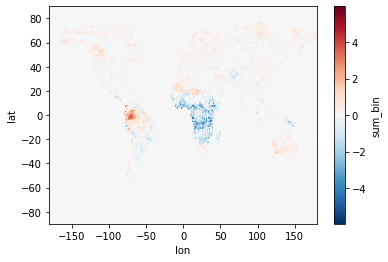

In [139]:
pl1 = mean_sum_bin_future - mean_sum_bin_hist
pl1.plot()

In [ ]:
pl2 = mean_sum_bin_future - mean_sum_bin_hist
pl2.plot()

In [142]:
t = pl1-pl2

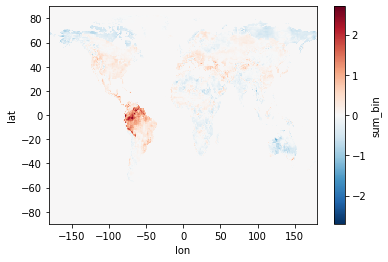

In [143]:
t.plot()

In [ ]:
###tests#### 

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
#combinations = list(itertools.product(models, model_names))

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for i in range(len(GCMs)):  # Iterate over the range of GCMs length
            GCM = GCMs[i]
            bioscen_GCM = bioscen_GCMs[i]
            print("GCM", GCM)
            for scenario in scenarios:
                print ("Scneario", scenario)
                for l, ssprcp_short in enumerate(ssprcps_shorts):

                    convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                    dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                    dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                    available_file = os.listdir(dir_species)
                    available_names = [x.split(".csv")[0] for x in available_file]

                    formatted_names = []

                    for species_name in available_names:
                        split_species_name = species_name.split("_")[:2]
                        formatted_species_name = " ".join(split_species_name)
                        formatted_names.append(formatted_species_name)

                    results = []
                    for i, species_name in enumerate(formatted_names[:1]):
                        formatted_species_name = species_name.replace(" ", "_")

                        for file_name in available_file:
                            if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                species_file = file_name
                                species_file2 = [x.split(".csv")[0] for x in species_file] 
                                break
                        else:
                            bioscen_species = None
                            continue
                            
                        bioscen_species = pd.read_csv(dir_species + file_name)

                        available_files_iucn = formatted_species_name + ".csv"
                        if available_files_iucn in os.listdir(dir_habclass):
                            IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                        else:
                            continue

                        lon = bioscen_species["x"]
                        lat = bioscen_species["y"]
                        z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                        df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                        df = df.fillna(0)
                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                            Habitats.drop('LUH', axis=1, inplace=True)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                        LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                        #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                        ncfname = LandUseList
                        da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                        da_landuse = da_landuse.isel(time=time)

                        #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                        df_sdm =df

                        #build an empty np.array 
                        np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                        #isimip_lats = isimip['lat'].values
                        #isimip_lons = isimip['lon'].values

                        lats = da_landuse['lat'].values
                        lons = da_landuse['lon'].values

                        da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                        da_landclim = da_empty.assign_attrs(da_landuse)

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                        latitudes = df_sdm['lat'].unique()
                        longitudes = df_sdm['lon'].unique()

                        lats_sorted = np.sort(latitudes)
                        lons_sorted = np.sort(longitudes)

                       # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                        sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                        # Initialize the newvalue_array with NaNs instead of zeros
                        newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                        # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                        for i, lat in enumerate(lats_sorted):
                            for j, lon in enumerate(lons_sorted):
                                vals = sdm_dict.get((lat, lon), np.nan)
                                if not np.isnan(vals):
                                    newvalue_array[i, j] = vals


                        da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                        # Interpolate the values of newvalue to the dimensions of A
                        interpolated_values = da.interp(lat=lats, lon=lons)

                        # Add the interpolated values to the A DataArray
                        da_landuse['newvalue'] = interpolated_values
                        da_landuse['newvalue'] = interpolated_values.fillna(0)

                        #da_landuse['newvalue'] = da_landuse['newvalue'].where(~np.isnan(da_landuse['primf']))


                        keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                        keys = list(set(keys))
                        for variable in list(da_landuse.keys()):
                            if variable not in keys and variable != "newvalue":
                                del da_landuse[variable]
                                
                                

                        num_codes = 0
                        for code in keys: 
                            # Check if the code is "MARINE" and skip land-use filter if it is
                            if code == "MARINE":
                                pass
                            else:
                                num_codes += 1
                                # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                                da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]

                                da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                # Select the DataArrays ending in "_bin"
                                bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                # Multiply all the arrays together
                                sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)

                                # Assign the "product_bin" attribute to the da_landuse DataArray
                                da_landuse["sum_bin"] = sum_bin
                                da_landuse["sum_lu_binary"] = sum_lu_binary
                                da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes


                                print("Size of da_landuse in megabytes (MB): ", da_landuse.nbytes / (1024 * 1024))


                                #output_directory = "/storage/scratch/users/ch21o450/data/test/" + model+ "/" + taxa + "/" + GCM + "/" + scenario + "/"
                                #os.makedirs(output_directory, exist_ok=True)

                                

                       # Create a new column with binary values (0 or 1) based on the condition if landuse[code] is greater than 0


In [16]:
da_landuse

<xarray.Dataset>
Dimensions:                 (time: 1, lon: 720, lat: 360)
Coordinates:
  * time                    (time) float64 35.0
  * lon                     (lon) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
  * lat                     (lat) float64 89.75 89.25 88.75 ... -89.25 -89.75
Data variables: (12/16)
    primn                   (time, lat, lon) float32 nan nan nan ... nan nan nan
    secdn                   (time, lat, lon) float32 nan nan nan ... nan nan nan
    newvalue                (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    primn_bin               (time, lat, lon) float64 nan nan nan ... nan nan nan
    primn_binary            (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    primn_lu_binary         (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                      ...
    sum_poo_lu_binary       (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sum_poo_lu_binary_norm  (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    secdn_bin               (time, lat, lon) float64 nan nan nan ... nan nan nan
    secdn_binary            (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    secdn_lu_binary         (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    secdn_poo_lu_binary     (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/28)
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.6
    source:                  LUH2 v2.1f: Land-Use Harmonization Data Set
    institution:             University of Maryland (UofMD), College Park, MD...
    host:                    UMD College Park
    comment:                 LUH2
    ...                      ...
    source_id:               UofMD-landState-GCAM-ssp460-2-1-f
    variable_id:             multiple-states
    tracking_id:             hdl:21.14100/8fd188aa-2367-41e4-817b-61c41202ca38
    history:                 Sun Mar 05 15:23:55 2023: cdo remapbil,gfdl-esm4...
    NCO:                     netCDF Operators version 5.0.6 (Homepage = http:...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [ ]:
da_landuse['sum_bin'].plot()

In [ ]:
da_landuse['newvalue'].plot()

In [ ]:
import netCDF4

In [ ]:
###tests#### 

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
#combinations = list(itertools.product(models, model_names))

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for i in range(len(GCMs)):  # Iterate over the range of GCMs length
            GCM = GCMs[i]
            bioscen_GCM = bioscen_GCMs[i]
            print("GCM", GCM)
            for scenario in scenarios:
                print ("Scneario", scenario)
                for l, ssprcp_short in enumerate(ssprcps_shorts):

                    convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                    dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                    dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                    available_file = os.listdir(dir_species)
                    available_names = [x.split(".csv")[0] for x in available_file]

                    formatted_names = []

                    for species_name in available_names:
                        split_species_name = species_name.split("_")[:2]
                        formatted_species_name = " ".join(split_species_name)
                        formatted_names.append(formatted_species_name)

                    results = []
                    for i, species_name in enumerate(formatted_names[:3]):
                        formatted_species_name = species_name.replace(" ", "_")

                        for file_name in available_file:
                            if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                species_file = file_name
                                species_file2 = [x.split(".csv")[0] for x in species_file] 
                                break
                        else:
                            bioscen_species = None
                            continue
                            
                        bioscen_species = pd.read_csv(dir_species + file_name)

                        available_files_iucn = formatted_species_name + ".csv"
                        if available_files_iucn in os.listdir(dir_habclass):
                            IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                        else:
                            continue

                        lon = bioscen_species["x"]
                        lat = bioscen_species["y"]
                        z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                        df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                        df = df.fillna(0)
                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                            Habitats.drop('LUH', axis=1, inplace=True)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                        LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                        #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                        ncfname = LandUseList
                        da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                        da_landuse = da_landuse.isel(time=time)

                        #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                        df_sdm =df

                        #build an empty np.array 
                        np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                        #isimip_lats = isimip['lat'].values
                        #isimip_lons = isimip['lon'].values

                        lats = da_landuse['lat'].values
                        lons = da_landuse['lon'].values

                        da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                        da_landclim = da_empty.assign_attrs(da_landuse)

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                        latitudes = df_sdm['lat'].unique()
                        longitudes = df_sdm['lon'].unique()

                        lats_sorted = np.sort(latitudes)
                        lons_sorted = np.sort(longitudes)

                       # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                        sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                        # Initialize the newvalue_array with NaNs instead of zeros
                        newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                        # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                        for i, lat in enumerate(lats_sorted):
                            for j, lon in enumerate(lons_sorted):
                                vals = sdm_dict.get((lat, lon), np.nan)
                                if not np.isnan(vals):
                                    newvalue_array[i, j] = vals


                        da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                        # Interpolate the values of newvalue to the dimensions of A
                        interpolated_values = da.interp(lat=lats, lon=lons)

                        # Add the interpolated values to the A DataArray
                        da_landuse['newvalue'] = interpolated_values
                        da_landuse['newvalue'] = interpolated_values.fillna(0)


                        keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                        keys = list(set(keys))

                       # category_mapping
                        category_mapping = {
                            'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
                            'pasture': ['pastr', 'range'],
                            'forest': ['primf', 'secdf'],
                            'natural_land': ['primn', 'secdn'],
                            'urban':['urban']
                        }

                        num_codes = 0
                        for code in keys:
                            if code == "MARINE":
                                pass
                            else:
                                num_codes += 1
                                # Check if the code exists in the category_mapping
                                for category, codes in category_mapping.items():
                                    # Initialize sum array for the category
                                    da_landuse[f"{category}_sum"] = xr.zeros_like(da_landuse[codes[0]])

                                    for code in codes:
                                        da_landuse[f"{category}_sum"] += da_landuse[code]

                                        # Compute the product with the sum of the codes and the "newvalue" column
                                        da_landuse[f"{category}_bin"] = da_landuse[f"{category}_sum"] * da_landuse["newvalue"]

                        # Create a list of category sum arrays
                        bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "total_category_sum"]

                        # Then you could sum these arrays if needed:
                        total_category_sum =  xr.concat(bin_arrays, dim='new_dim').sum(dim='new_dim')

                        da_landuse["total_category_sum"] = total_category_sum
                        output_directory = "/storage/scratch/users/ch21o450/data/try/" + model+ "/" + taxa + "/" + GCM + "/" + scenario + "/"
                        os.makedirs(output_directory, exist_ok=True)
                        da_landuse.to_netcdf(output_directory + formatted_species_name + "_" + str(time) + ".nc",'w')



In [ ]:
output_directory


In [ ]:
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
#combinations = list(itertools.product(models, model_names))

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        print("Taxa", taxa)
        print("Model", model)
        print("Time", time[0])
        for i in range(len(GCMs)):  # Iterate over the range of GCMs length
            GCM = GCMs[i]
            bioscen_GCM = bioscen_GCMs[i]
            print("GCM", GCM)
            for scenario in scenarios:
                print ("Scneario", scenario)
                for l, ssprcp_short in enumerate(ssprcps_shorts):

                    convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                    dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                    dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                    available_file = os.listdir(dir_species)
                    available_names = [x.split(".csv")[0] for x in available_file]

                    formatted_names = []

                    for species_name in available_names:
                        split_species_name = species_name.split("_")[:2]
                        formatted_species_name = " ".join(split_species_name)
                        formatted_names.append(formatted_species_name)

                    results = []
                    for i, species_name in enumerate(formatted_names[:1]):
                        formatted_species_name = species_name.replace(" ", "_")

                        for file_name in available_file:
                            if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                species_file = file_name
                                species_file2 = [x.split(".csv")[0] for x in species_file] 
                                break
                        else:
                            bioscen_species = None
                            continue

                        bioscen_species = pd.read_csv(dir_species + file_name)

                        available_files_iucn = formatted_species_name + ".csv"
                        if available_files_iucn in os.listdir(dir_habclass):
                            IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                        else:
                            continue

                        lon = bioscen_species["x"]
                        lat = bioscen_species["y"]
                        z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                        df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                        df = df.fillna(0)
                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                            Habitats.drop('LUH', axis=1, inplace=True)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                        LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                        #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                        ncfname = LandUseList
                        da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                        da_landuse = da_landuse.isel(time=time)

                        #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                        df_sdm =df

                        #build an empty np.array 
                        np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                        #isimip_lats = isimip['lat'].values
                        #isimip_lons = isimip['lon'].values

                        lats = da_landuse['lat'].values
                        lons = da_landuse['lon'].values

                        da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                        da_landclim = da_empty.assign_attrs(da_landuse)

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                        latitudes = df_sdm['lat'].unique()
                        longitudes = df_sdm['lon'].unique()

                        lats_sorted = np.sort(latitudes)
                        lons_sorted = np.sort(longitudes)

                       # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                        sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                        # Initialize the newvalue_array with NaNs instead of zeros
                        newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                        # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                        for i, lat in enumerate(lats_sorted):
                            for j, lon in enumerate(lons_sorted):
                                vals = sdm_dict.get((lat, lon), np.nan)
                                if not np.isnan(vals):
                                    newvalue_array[i, j] = vals


                        da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                        # Interpolate the values of newvalue to the dimensions of A
                        interpolated_values = da.interp(lat=lats, lon=lons)

                        # Add the interpolated values to the A DataArray
                        da_landuse['newvalue'] = interpolated_values
                        da_landuse['newvalue'] = interpolated_values.fillna(0)


                        keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                        keys = list(set(keys))

                       # category_mapping
                        category_mapping = {
                            'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
                            'pasture': ['pastr', 'range'],
                            'forest': ['primf', 'secdf'],
                            'natural_land': ['primn', 'secdn'],
                            'urban':['urban']
                        }

                        num_codes = 0
                        for code in keys:
                            if code == "MARINE":
                                pass
                            else:
                                num_codes += 1
                                # Check if the code exists in the category_mapping
                                for category, codes in category_mapping.items():
                                    # Initialize sum array for the category
                                    da_landuse[f"{category}_sum"] = xr.zeros_like(da_landuse[codes[0]])

                                    for code in codes:
                                        da_landuse[f"{category}_sum"] += da_landuse[code]

                                        # Compute the product with the sum of the codes and the "newvalue" column
                                        da_landuse[f"{category}_bin"] = da_landuse[f"{category}_sum"] * da_landuse["newvalue"]

                                        # Create a list of category sum arrays
                                        bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "total_category_sum"]

                                        # Then you could sum these arrays if needed:
                                        total_category_sum =  xr.concat(bin_arrays, dim='new_dim').sum(dim='new_dim')
                                        
                                        da_landuse["total_category_sum"] = total_category_sum

                                        output_directory = "/storage/scratch/users/ch21o450/data/new/" + model+ "/" + taxa + "/" + GCM + "/" + scenario + "/"
                                        os.makedirs(output_directory, exist_ok=True)

                                        da_landuse.to_netcdf(output_directory + formatted_species_name + "_" + str(time) + ".nc")

In [ ]:
da_landuse["newvalue"].plot()

In [ ]:
da_landuse

In [ ]:
da_landuse["forest_bin"].plot()

In [ ]:
sub_categories

In [ ]:
da_landuse

In [ ]:
# category_mapping
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forest': ['primf', 'secdf'],
    'natural_land': ['primn', 'secdn'],
    'urban':['urban']
}

# iterate over the category_mapping
for category, sub_categories in category_mapping.items():
    da_landuse[category] = da_landuse[sub_categories].sum(dim='sub_category') # sum up the sub categories
    da_landuse[category] = da_landuse[category] * da_landuse['newvalue']  # multiply with the "newvalue"


In [ ]:
code

In [ ]:
da_landuse["sum_bin"].plot()

In [ ]:
Habitats

In [ ]:
Habitats_suitable

In [ ]:
sum_lu_binary.plot()

In [ ]:
#### Mammals and Amphibians #### 

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
combinations = list(itertools.product(models, model_names))

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for GCM in GCMs:
            for bioscen_GCM in bioscen_GCMs:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:1]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                           # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                            sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                            # Initialize the newvalue_array with NaNs instead of zeros
                            newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                            # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    vals = sdm_dict.get((lat, lon), np.nan)
                                    if not np.isnan(vals):
                                        newvalue_array[i, j] = vals


                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            
                               
                            keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                            keys = list(set(keys))

                            num_codes = 0
                            for code in keys: 
                                # Check if the code is "MARINE" and skip land-use filter if it is
                                if code == "MARINE":
                                    pass
                                else:
                                    num_codes += 1
                                    # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                    np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                    da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]
                                    
                                    da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                    da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]
                                    
                                    da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                    da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                    # Select the DataArrays ending in "_bin"
                                    bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                    binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                    binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                    # Multiply all the arrays together
                                    sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                    sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                    sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)
                                    
                                    # Assign the "product_bin" attribute to the da_landuse DataArray
                                    da_landuse["sum_bin"] = sum_bin
                                    da_landuse["sum_lu_binary"] = sum_lu_binary
                                    da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                    da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes
                                    
                                    difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                    da_landuse["difference_filter"] = difference

                                    da_landclim = da_landclim.assign_attrs(da_landuse)
                                    #da_landuse.to_netcdf("/storage/scratch/users/ch21o450/data/LandClim_Output/" + model+ "/" + taxa + "/" + model_name + "/" + scenario + "/" + formatted_species_name + "_" + str(time)+ ".nc")

                            
                           # Create a new column with binary values (0 or 1) based on the condition if landuse[code] is greater than 0
        




In [ ]:
da_landuse["sum_bin"].mean()

In [ ]:
 da_landuse["sum_bin"].plot()

In [ ]:
####  birds #### 
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
combinations = list(itertools.product(models, model_names))
    # Load necessary data
convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
taxas=["Bird"]


for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:1000]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_predict.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            keys = ["primn" if row[f"LUH{i}"] == "primn" else row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]
                            keys = list(set(keys))

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                           # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                            sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                            # Initialize the newvalue_array with NaNs instead of zeros
                            newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                            # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    vals = sdm_dict.get((lat, lon), np.nan)
                                    if not np.isnan(vals):
                                        newvalue_array[i, j] = vals


                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            
                               
                            keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                            keys = list(set(keys))

                            num_codes = 0
                            for code in keys: 
                                # Check if the code is "MARINE" and skip land-use filter if it is
                                if code == "MARINE":
                                    pass
                                else:
                                    num_codes += 1
                                    # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                    np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                    da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]
                                    
                                    da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                    da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]
                                    
                                    da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                    da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                    # Select the DataArrays ending in "_bin"
                                    bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                    binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                    binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                    # Multiply all the arrays together
                                    sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                    sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                    sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)
                                    
                                    # Assign the "product_bin" attribute to the da_landuse DataArray
                                    da_landuse["sum_bin"] = sum_bin
                                    da_landuse["sum_lu_binary"] = sum_lu_binary
                                    da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                    da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes
                                    
                                    difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                    da_landuse["difference_filter"] = difference

                                    da_landclim = da_landclim.assign_attrs(da_landuse)
                                    da_landuse.to_netcdf("/storage/scratch/users/ch21o450/data/LandClim_Output/" + model+ "/" + taxa + "/" + model_name + "/" + scenario + "/" + formatted_species_name + "_" + str(time)+ ".nc")

                            
                         

In [ ]:
#### birds hist ####


time=[1146]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {1146:2,35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 1146:
    model_names = ['EWEMBI']
    bioscen_model_names = ['EWEMBI']
       
combinations = list(itertools.product(models, model_names))
    # Load necessary data
convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")

taxas=["Bird"]

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:

                convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                available_file = os.listdir(dir_species)
                available_names = [x.split(".csv")[0] for x in available_file]

                formatted_names = []

                for species_name in available_names:
                    split_species_name = species_name.split("_")[:2]
                    formatted_species_name = " ".join(split_species_name)
                    formatted_names.append(formatted_species_name)

                results = []
                for i, species_name in enumerate(formatted_names[:1000]):
                    formatted_species_name = species_name.replace(" ", "_")

                    for file_name in available_file:
                        if formatted_species_name in file_name and model + '_predict.csv.xz' in file_name:
                            species_file = file_name
                            species_file2 = [x.split(".csv")[0] for x in species_file] 
                            break
                    else:
                        bioscen_species = None
                        continue

                    bioscen_species = pd.read_csv(dir_species + file_name)

                    available_files_iucn = formatted_species_name + ".csv"
                    if available_files_iucn in os.listdir(dir_habclass):
                        IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                    else:
                        continue

                    lon = bioscen_species["x"]
                    lat = bioscen_species["y"]
                    z = bioscen_species[bioscen_model_name + '_' + selected_year]

                    df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                    df = df.fillna(0)
                    convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                    IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                    Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                    keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                    split_cols = Habitats['LUH'].str.split('.', expand=True)
                    for i, key in enumerate(keys):
                        if i < len(split_cols.columns):
                            Habitats[key] = split_cols[i]
                        else:
                            Habitats[key] = pd.Series(dtype='float64')
                    if len(Habitats.columns) > len(keys) + 1:
                        num_missing_cols = len(Habitats.columns) - len(keys) - 1
                        Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                        Habitats.drop('LUH', axis=1, inplace=True)
                    Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                    LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_historical.nc"

                    #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                    ncfname = LandUseList
                    da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                    da_landuse = da_landuse.isel(time=time)

                    #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                    df_sdm =df

                    #build an empty np.array 
                    np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                    #isimip_lats = isimip['lat'].values
                    #isimip_lons = isimip['lon'].values

                    lats = da_landuse['lat'].values
                    lons = da_landuse['lon'].values

                    da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                    da_landclim = da_empty.assign_attrs(da_landuse)

                    # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                    # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                    latitudes = df_sdm['lat'].unique()
                    longitudes = df_sdm['lon'].unique()

                    lats_sorted = np.sort(latitudes)
                    lons_sorted = np.sort(longitudes)

                   # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                    sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                    # Initialize the newvalue_array with NaNs instead of zeros
                    newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                    # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                    for i, lat in enumerate(lats_sorted):
                        for j, lon in enumerate(lons_sorted):
                            vals = sdm_dict.get((lat, lon), np.nan)
                            if not np.isnan(vals):
                                newvalue_array[i, j] = vals


                    da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                    # Interpolate the values of newvalue to the dimensions of A
                    interpolated_values = da.interp(lat=lats, lon=lons)

                    # Add the interpolated values to the A DataArray
                    da_landuse['newvalue'] = interpolated_values
                    da_landuse['newvalue'] = interpolated_values.fillna(0)


                    keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                    keys = list(set(keys))

                    num_codes = 0
                    for code in keys: 
                        # Check if the code is "MARINE" and skip land-use filter if it is
                        if code == "MARINE":
                            pass
                        else:
                            num_codes += 1
                            # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                            np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                            da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                            da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                            da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]

                            da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                            da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                            # Select the DataArrays ending in "_bin"
                            bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                            binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                            binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                            # Multiply all the arrays together
                            sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                            sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                            sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)

                            # Assign the "product_bin" attribute to the da_landuse DataArray
                            da_landuse["sum_bin"] = sum_bin
                            da_landuse["sum_lu_binary"] = sum_lu_binary
                            da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                            da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes

                            difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                            da_landuse["difference_filter"] = difference

                            da_landclim = da_landclim.assign_attrs(da_landuse)

In [ ]:
IUCN

In [ ]:
IUCN

In [ ]:
convcodes_renamed['result.code'] = convcodes_renamed['result.code'].astype(float)
convcodes_renamed

In [ ]:
IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
print(IUCN)


In [ ]:
 Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

In [ ]:
Habitats

In [ ]:
da_landuse["sum_poo_lu_binary_norm"].plot()


In [ ]:
bioscen_species.head().to_markdown()
